# Knock Airport Weather

## Data retrieval & Cleaning

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# first 23 rows describe the columns, need to skip these to get the data
df = pd.read_csv("https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv", skiprows=23)
df.head()

/var/folders/s7/bsy4w2n54pvcvlbx9jg9h2040000gn/T/ipykernel_83797/1596145377.py:5: DtypeWarning: Columns (2,10,12,14,15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv", skiprows=23)


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
0,10-apr-1996 14:00,0,0.0,0,11.5,0,8.1,3.9,0.0,0,...,0,0,0,0,25,81,0.0,35000,32,5
1,31-jul-1996 08:00,0,0.0,0,11.5,0,11.1,10.7,0.0,0,...,0,0,0,0,25,82,0.0,40000,45,5
2,31-jul-1996 09:00,0,0.0,0,11.6,0,10.7,9.8,0.0,0,...,0,0,0,0,80,81,0.0,8000,32,7
3,31-jul-1996 10:00,0,0.0,0,12.9,0,11.3,9.8,0.0,0,...,0,0,0,0,25,82,0.0,28000,35,6
4,31-jul-1996 11:00,0,0.0,0,14.5,0,10.8,7.0,0.0,0,...,0,0,0,0,2,11,0.0,40000,40,6


In [5]:
# we only need the temperature and windspeed
df = df[['date', 'temp', 'wdsp']]
df.head()

,date,temp,wdsp
0,10-apr-1996 14:00,11.5,0
1,31-jul-1996 08:00,11.5,0
2,31-jul-1996 09:00,11.6,0
3,31-jul-1996 10:00,12.9,0
4,31-jul-1996 11:00,14.5,0


In [6]:
# date is stored as a string instead of a datetime, and wdsp is an object
df.dtypes

date     object
temp    float64
wdsp     object
dtype: object

In [12]:
# %b is the 3 letter month abbrevaition
df.date = pd.to_datetime(df.date, format='%d-%b-%Y %H:%S')

# some windspeeds are recorded as just a space " " which makes the whole column a string
# when converting to numeric coerce errors to NaN values
df.wdsp = pd.to_numeric(df.wdsp, errors='coerce')
df

,date,temp,wdsp
0,1996-04-10 14:00:00,11.5,0.0
1,1996-07-31 08:00:00,11.5,0.0
2,1996-07-31 09:00:00,11.6,0.0
3,1996-07-31 10:00:00,12.9,0.0
4,1996-07-31 11:00:00,14.5,0.0
...,...,...,...
248389,2024-11-30 20:00:00,11.6,17.0
248390,2024-11-30 21:00:00,11.4,16.0
248391,2024-11-30 22:00:00,10.9,15.0
248392,2024-11-30 23:00:00,10.8,14.0


In [14]:
df.describe()

,date,temp,wdsp
count,248394,248394.000000,248344.000000
mean,2010-10-01 03:29:21.143988992,8.762963,9.454744
min,1996-04-10 14:00:00,-6.900000,0.000000
25%,2003-08-31 17:15:00,5.400000,6.000000
50%,2010-10-01 03:30:00,8.800000,9.000000
75%,2017-10-31 13:45:00,12.000000,12.000000
max,2024-12-01 00:00:00,28.500000,50.000000
std,NaN,4.604485,4.935574


In [19]:
df.isna().sum()

date     0
temp     0
wdsp    50
dtype: int64

In [21]:
# 50 windspeed values are null, impute them with the previous non-null value sorted by date
df = df.sort_values('date').ffill().copy()
df.head()

,date,temp,wdsp
0,1996-04-10 14:00:00,11.5,0.0
1,1996-07-31 08:00:00,11.5,0.0
2,1996-07-31 09:00:00,11.6,0.0
3,1996-07-31 10:00:00,12.9,0.0
4,1996-07-31 11:00:00,14.5,0.0


## Temperature Plots

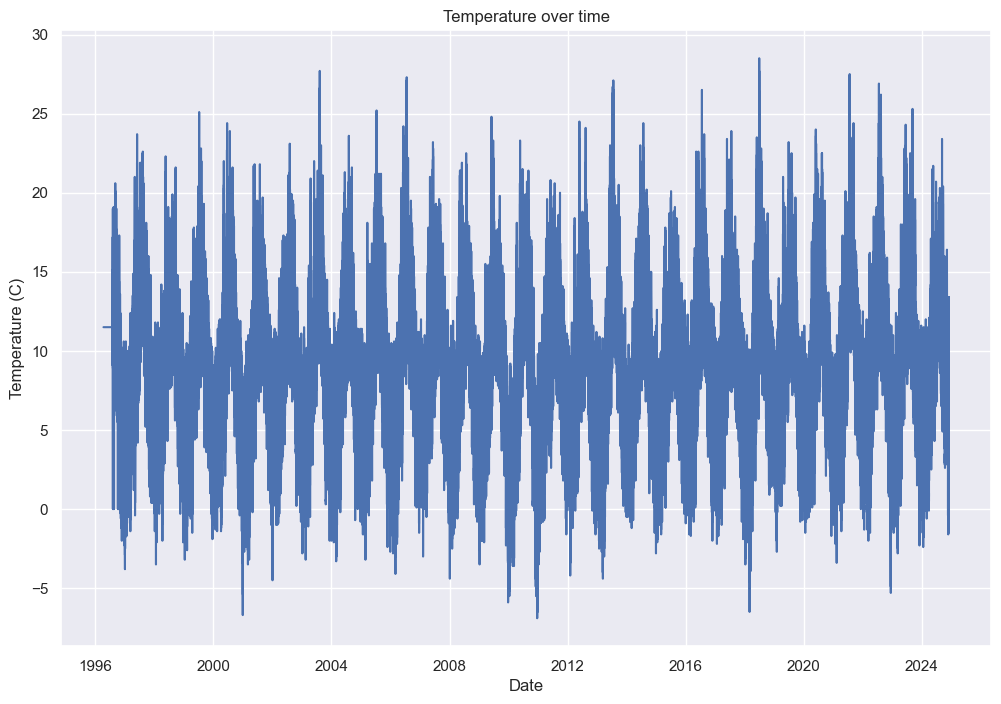

In [23]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=df, x='date', y='temp')
plt.title('Temperature over time')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.show()

In [30]:
# group by the date and get the mean of the numeric columns 
daily_data = df.rename(columns={'date':'datetime'}).groupby(df.date.dt.date)[['temp', 'wdsp']].aggregate('mean').reset_index()

daily_data.head()

,date,temp,wdsp
0,1996-04-10,11.500000,0.000000
1,1996-07-31,12.650000,0.000000
2,1996-08-01,11.666667,9.916667
3,1996-08-02,12.504167,7.625000
4,1996-08-03,14.266667,6.666667


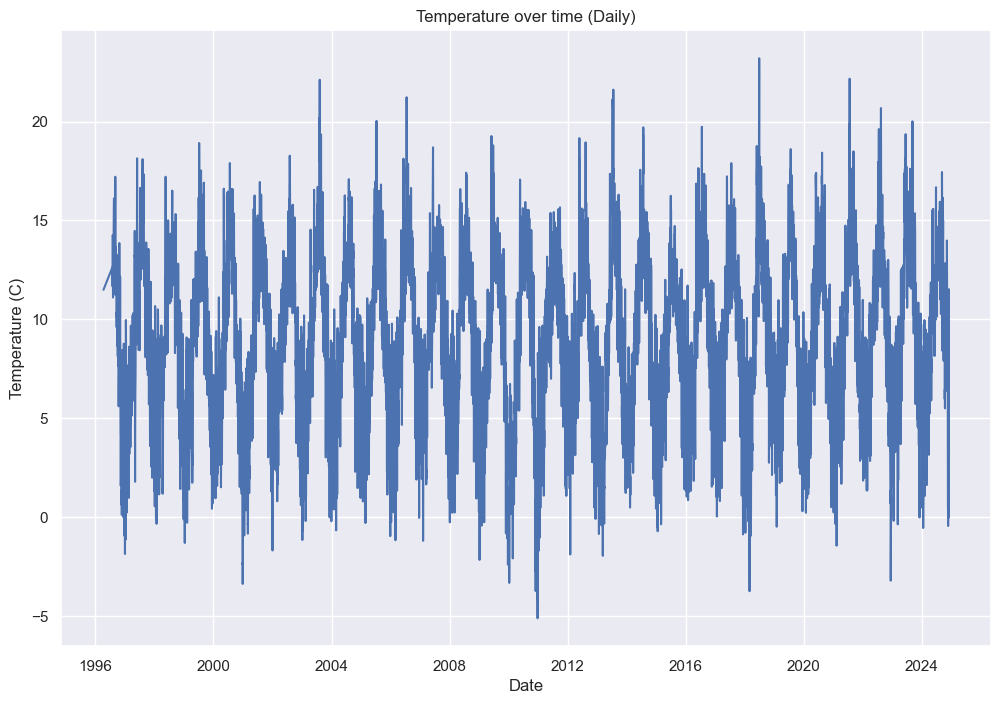

In [51]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=daily_data, x='date', y='temp')
plt.title('Temperature over time (Daily)')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.show()

In [50]:
# This gives averages over the months, as in the February average across all years
# df.rename(columns={'date':'datetime'})\
#     .groupby(df.date.dt.month)[['temp', 'wdsp']]\
#     .aggregate('mean').reset_index()

# monthly_data = df.rename(columns={'date':'datetime'})\
#     .groupby([df.date.dt.year, df.date.dt.month])[['temp', 'wdsp']]\
#     .aggregate('mean').reset_index(names=['year', 'month'])

# https://stackoverflow.com/questions/26646191/pandas-groupby-month-and-year
# make the index a datetimeindex and then use a monthly grouper to aggregate
monthly_df = df.rename(columns={'date':'datetime'})\
    .set_index('datetime')\
    .groupby(pd.Grouper(freq='ME'))[['temp', 'wdsp']]\
    .aggregate('mean')\
    .reset_index()\
    .dropna(axis=0, how='any')

monthly_df.head()

,datetime,temp,wdsp
0,1996-04-30,11.500000,0.000000
3,1996-07-31,12.650000,0.000000
4,1996-08-31,12.946909,8.397849
5,1996-09-30,12.174306,8.047222
6,1996-10-31,9.614113,11.608871


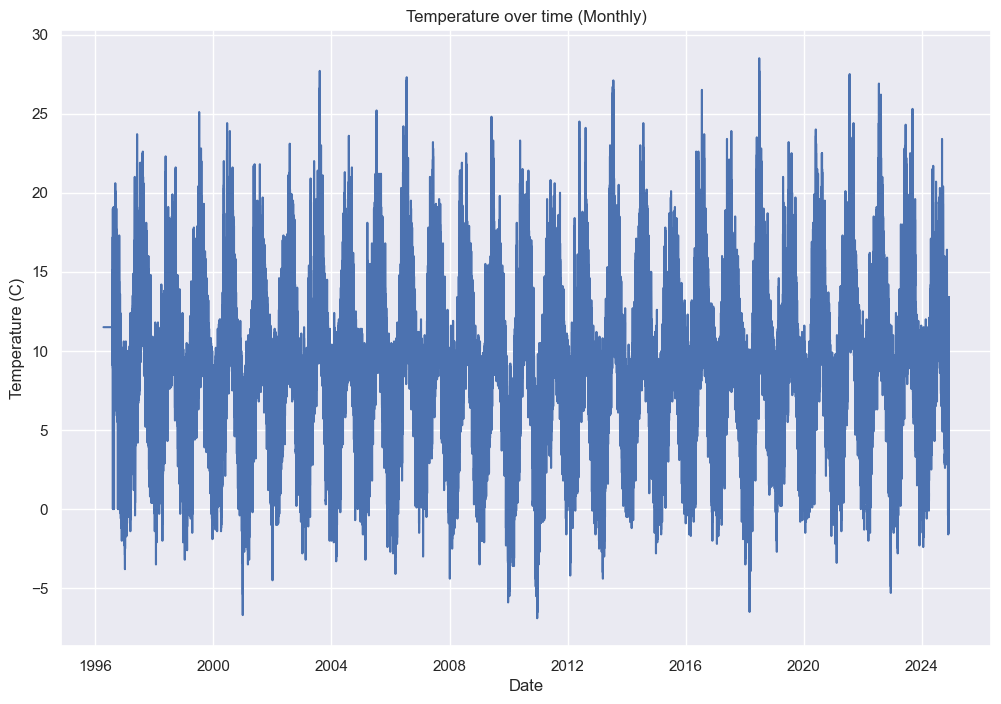

In [52]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=monthly_data, x='datetime', y='temp')
plt.title('Temperature over time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.show()

In [58]:
monthly_df_2 = df.rename(columns={'date':'datetime'})\
    .groupby(df.date.dt.month)[['temp', 'wdsp']]\
    .aggregate('mean').reset_index()
monthly_df_2['month'] = pd.to_datetime(monthly_df_2.date, format='%m').dt.month_name()
monthly_df_2


,date,temp,wdsp,month
0,1,4.348502,10.473742,January
1,2,4.686452,10.974979,February
2,3,5.625178,10.118856,March
3,4,7.519131,9.383265,April
4,5,10.212284,9.187980,May
5,6,12.366806,8.656994,June
6,7,13.650432,8.170952,July
7,8,13.561267,8.467557,August
8,9,12.092390,8.830603,September
9,10,9.328369,9.483129,October


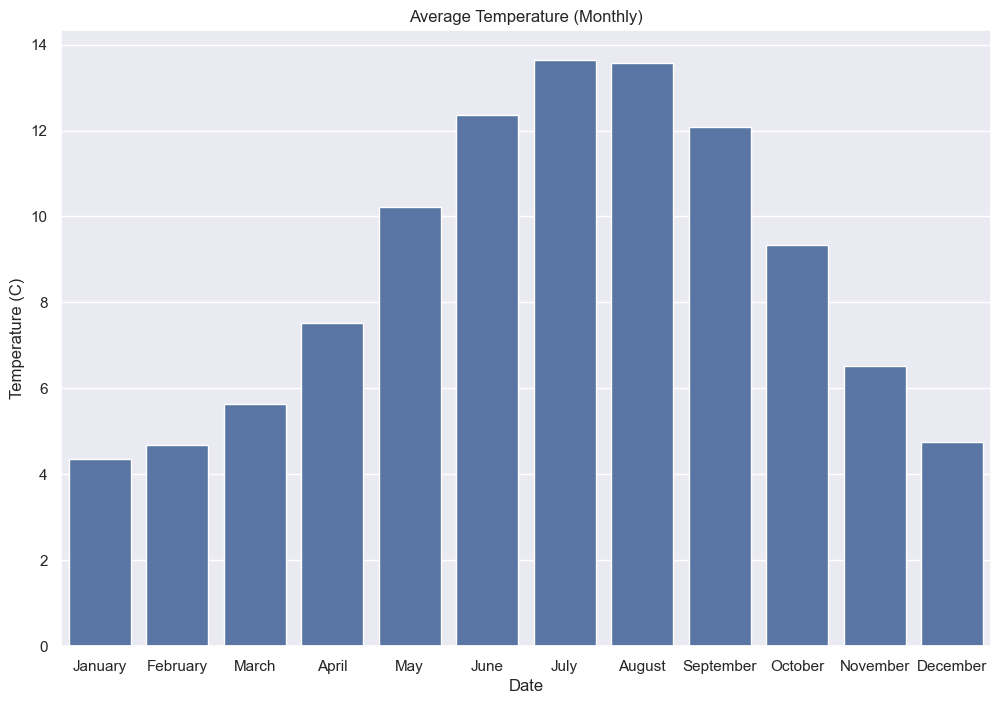

In [60]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.barplot(data=monthly_df_2, x='month', y='temp')
plt.title('Average Temperature (Monthly)')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.show()

## Windspeed Plots

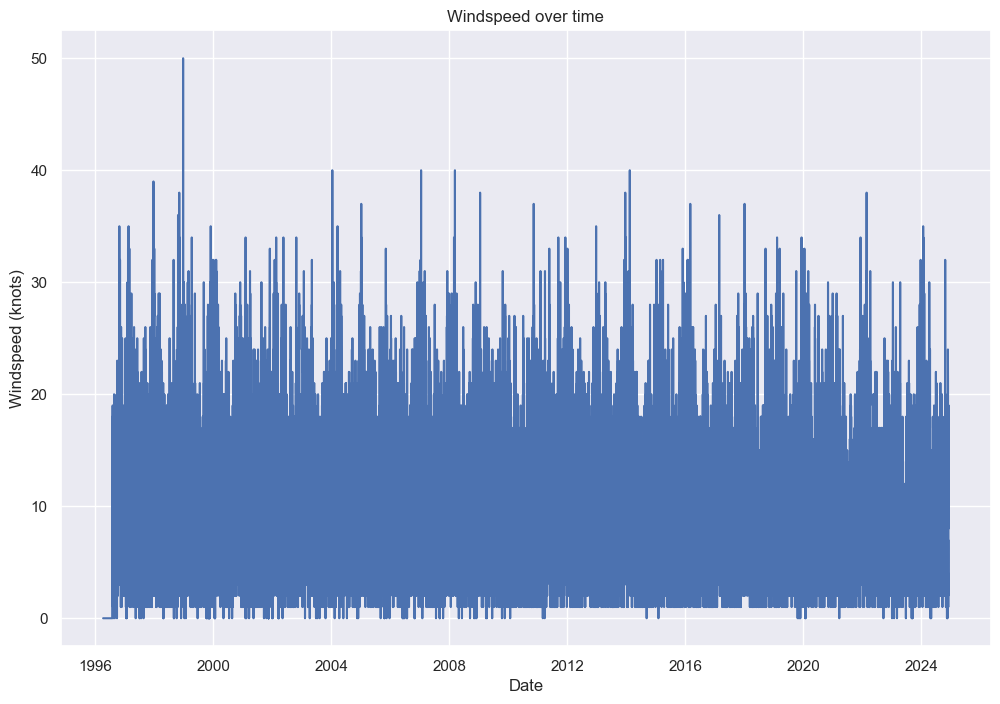

In [61]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=df, x='date', y='wdsp')
plt.title('Windspeed over time')
plt.xlabel('Date')
plt.ylabel('Windspeed (knots)')
plt.show()

In [67]:
rolling_df = df.set_index('date').rolling('24h').mean().reset_index()
rolling_df.head()

,date,temp,wdsp
0,1996-04-10 14:00:00,11.500,0.0
1,1996-07-31 08:00:00,11.500,0.0
2,1996-07-31 09:00:00,11.550,0.0
3,1996-07-31 10:00:00,12.000,0.0
4,1996-07-31 11:00:00,12.625,0.0


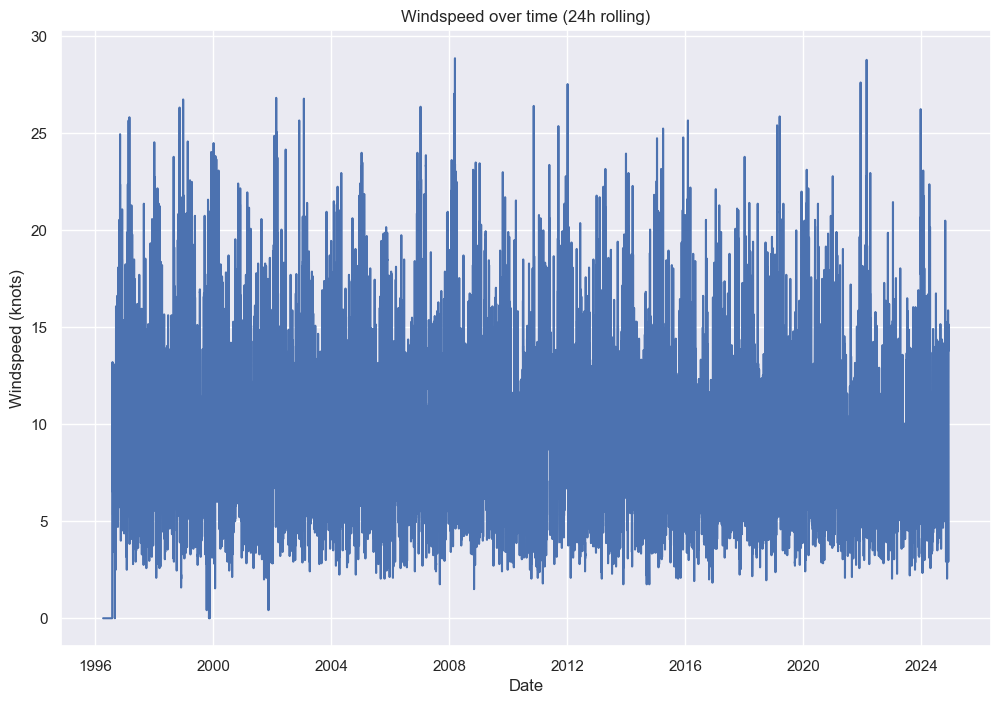

In [68]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=rolling_df, x='date', y='wdsp')
plt.title('Windspeed over time (24h rolling)')
plt.xlabel('Date')
plt.ylabel('Windspeed (knots)')
plt.show()

In [70]:
max_df = df.groupby(df.date.dt.date)[['wdsp']].max().reset_index(names=['date'])
max_df.head()

,date,wdsp
0,1996-04-10,0.0
1,1996-07-31,0.0
2,1996-08-01,14.0
3,1996-08-02,13.0
4,1996-08-03,10.0


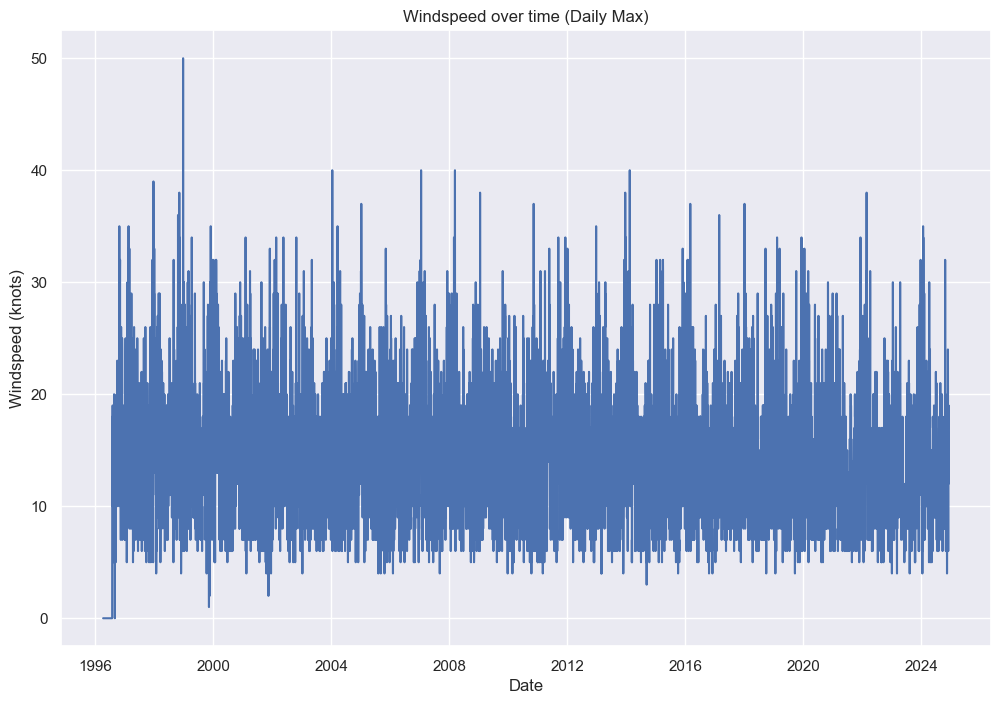

In [71]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=max_df, x='date', y='wdsp')
plt.title('Windspeed over time (Daily Max)')
plt.xlabel('Date')
plt.ylabel('Windspeed (knots)')
plt.show()

In [77]:
# Make sure this is a datetime so the grouper can act on a DateTimeIndex
max_df.date = pd.to_datetime(max_df.date)
month_max_df = max_df\
    .set_index('date')\
    .groupby(pd.Grouper(freq='ME'))[['wdsp']]\
    .aggregate('mean')\
    .reset_index()\
    .dropna(axis=0, how='any')
    
month_max_df.head()

,date,wdsp
0,1996-04-30,0.000000
3,1996-07-31,0.000000
4,1996-08-31,12.516129
5,1996-09-30,12.266667
6,1996-10-31,18.193548


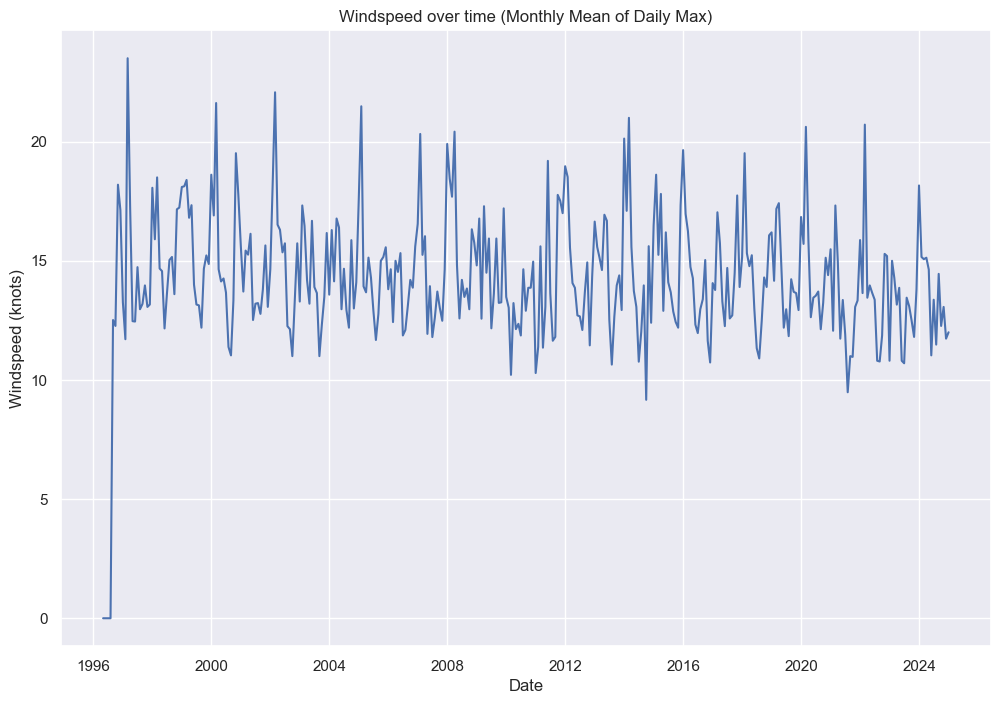

In [80]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(data=month_max_df, x='date', y='wdsp')
plt.title('Windspeed over time (Monthly Mean of Daily Max)')
plt.xlabel('Date')
plt.ylabel('Windspeed (knots)')
plt.show()